Starting Phase 4: GNN Models Implementation
Using device: cuda
Loaded 416 graphs
Number of node features per node: 1
Train: 265, Val: 67, Test: 84


C:\Users\rakes\anaconda3\envs\gnn_benchmark\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/100, Train Loss: 0.7156, Val F1: 0.4322
Epoch 10/100, Train Loss: 0.6137, Val F1: 0.5228
Epoch 20/100, Train Loss: 0.6106, Val F1: 0.5092
Epoch 30/100, Train Loss: 0.5524, Val F1: 0.4029
Epoch 40/100, Train Loss: 0.5824, Val F1: 0.5822
Epoch 50/100, Train Loss: 0.5775, Val F1: 0.5117
Epoch 60/100, Train Loss: 0.5318, Val F1: 0.5553
Epoch 70/100, Train Loss: 0.5371, Val F1: 0.5367
Epoch 80/100, Train Loss: 0.5888, Val F1: 0.5723
Epoch 90/100, Train Loss: 0.5793, Val F1: 0.5074
Epoch 100/100, Train Loss: 0.5451, Val F1: 0.5479
Final Test -- Acc: 0.6310, F1: 0.5534, Precision: 0.5552, Recall: 0.5687


C:\Users\rakes\AppData\Local\Temp\ipykernel_9892\2386547184.py:198: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  gcn_model.load_state_dict(torch.load(best_model_path))


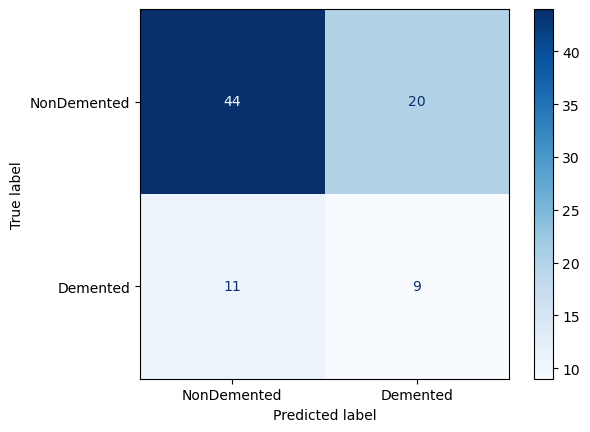

In [2]:
# %% 
# 03_Phase_4_GNN.ipynb
# Phase 4: GNN-based Brain Graph Classification
print("Starting Phase 4: GNN Models Implementation")

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
sys.path.append(os.path.abspath('..'))  # Adjust if needed
from config.paths import *

# Ensure device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# %% 
# 1. Load processed graph dataset
graph_dataset_path = os.path.join(PROCESSED_DIR, 'oasis_graph_dataset.pt')
graph_list = torch.load(graph_dataset_path, weights_only=False)
print(f"Loaded {len(graph_list)} graphs")

# Ensure node features are 2D
for graph in graph_list:
    if graph.x.dim() == 1:
        graph.x = graph.x.unsqueeze(1)  # shape: [num_nodes, 1]

num_node_features = graph_list[0].x.shape[1]
print("Number of node features per node:", num_node_features)

# %% 
# 2. Split dataset & create DataLoaders
from sklearn.model_selection import train_test_split

labels = [g.y.item() for g in graph_list]

train_graphs, test_graphs = train_test_split(graph_list, test_size=0.2, stratify=labels, random_state=42)
train_graphs, val_graphs = train_test_split(train_graphs, test_size=0.2, stratify=[g.y.item() for g in train_graphs], random_state=42)

train_loader = DataLoader(train_graphs, batch_size=16, shuffle=True)
val_loader = DataLoader(val_graphs, batch_size=16)
test_loader = DataLoader(test_graphs, batch_size=16)

print(f"Train: {len(train_graphs)}, Val: {len(val_graphs)}, Test: {len(test_graphs)}")

# %% 
# 3. Define GCN model
from torch_geometric.nn import global_mean_pool
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.bn1 = BatchNorm(hidden_channels)

        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.bn2 = BatchNorm(hidden_channels)

        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.bn3 = BatchNorm(hidden_channels)

        # Fully connected after pooling
        self.fc = nn.Linear(hidden_channels * 2, out_channels)  # *2 for mean+max pooling

        self.dropout = dropout

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        # Layer 1
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)

        # Layer 2
        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)

        # Layer 3
        x = self.conv3(x, edge_index)
        x = self.bn3(x)
        x = F.relu(x)

        # Dual pooling (mean + max)
        x_mean = global_mean_pool(x, batch)
        x_max = global_max_pool(x, batch)
        x = torch.cat([x_mean, x_max], dim=1)

        # Final classifier
        x = self.fc(x)
        return x

# %% 
# 4. Instantiate model, optimizer, loss
num_classes = 2
gcn_model = BrainGCN(in_channels=num_node_features, hidden_channels=64, out_channels=num_classes, dropout=0.5).to(device)
optimizer = torch.optim.Adam(gcn_model.parameters(), lr=0.001, weight_decay=5e-4)

# Compute class weights
class_counts = [316, 100]  # NonDemented, Demented
total_samples = sum(class_counts)
class_weights = torch.tensor([total_samples / (2.0 * c) for c in class_counts], dtype=torch.float).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

# %% 
# 5. Training and evaluation functions
def train_model(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0
    for data in loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs
    return total_loss / len(loader.dataset)

def evaluate_model(model, loader):
    model.eval()
    ys, preds = [], []
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data)
            pred = out.argmax(dim=1)
            ys.append(data.y.cpu())
            preds.append(pred.cpu())
    ys = torch.cat(ys)
    preds = torch.cat(preds)
    acc = accuracy_score(ys, preds)
    f1 = f1_score(ys, preds, average='macro')
    prec = precision_score(ys, preds, average='macro', zero_division=0)
    rec = recall_score(ys, preds, average='macro', zero_division=0)
    cm = confusion_matrix(ys, preds)
    return dict(accuracy=acc, f1=f1, precision=prec, recall=rec, cm=cm)

# %% 
# 6. Train GCN model
epochs = 100
best_f1 = 0
best_model_path = './gcn_best_model.pt'

for epoch in range(1, epochs + 1):
    train_loss = train_model(gcn_model, train_loader, optimizer, criterion)
    val_metrics = evaluate_model(gcn_model, val_loader)
    if val_metrics['f1'] > best_f1:
        best_f1 = val_metrics['f1']
        torch.save(gcn_model.state_dict(), best_model_path)
    if epoch % 10 == 0 or epoch == 1:
        print(f"Epoch {epoch}/{epochs}, Train Loss: {train_loss:.4f}, Val F1: {val_metrics['f1']:.4f}")

# %% 
# 7. Load best model and evaluate on test set
gcn_model.load_state_dict(torch.load(best_model_path))
test_metrics = evaluate_model(gcn_model, test_loader)

print(f"Final Test -- Acc: {test_metrics['accuracy']:.4f}, F1: {test_metrics['f1']:.4f}, "
      f"Precision: {test_metrics['precision']:.4f}, Recall: {test_metrics['recall']:.4f}")

# Display confusion matrix
ConfusionMatrixDisplay(confusion_matrix=test_metrics['cm'], display_labels=["NonDemented", "Demented"]).plot(cmap='Blues')
plt.show()


In [2]:
import torch
print(torch.__version__)
print(torch.version.cuda)


2.5.1
12.1


In [3]:
pip install torch-scatter -f https://data.pyg.org/whl/torch-2.5.1+cu121.html

Looking in links: https://data.pyg.org/whl/torch-2.5.1+cu121.html
     ---------------------------------------- 0.0/3.5 MB ? eta -:--:--
     ---------------------------------------- 0.0/3.5 MB ? eta -:--:--
     ---------------------------------------- 0.0/3.5 MB ? eta -:--:--
     ---------------------------------------- 0.0/3.5 MB ? eta -:--:--
     ---------------------------------------- 0.0/3.5 MB ? eta -:--:--
     -- ------------------------------------- 0.3/3.5 MB ? eta -:--:--
     -------- ------------------------------- 0.8/3.5 MB 2.1 MB/s eta 0:00:02
     -------- ------------------------------- 0.8/3.5 MB 2.1 MB/s eta 0:00:02
     ----------------- ---------------------- 1.6/3.5 MB 2.5 MB/s eta 0:00:01
     ---------------------------------------- 3.5/3.5 MB 3.8 MB/s  0:00:01
Note: you may need to restart the kernel to use updated packages.
